In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import geopandas as gpd

from shapely import wkt
from shapely.geometry import Point

from utils.dbutils import get_drought_codes_table

from pykrige.ok import OrdinaryKriging

import matplotlib.pyplot as plt

from pathlib import Path
from sqlalchemy import create_engine, text


from rasterio.features import geometry_mask
import rasterio
import numpy as np


First we load all the 'drought codes' data, which includes data on stations, freeze-up (freeze), melt (snowfree), and drought code metadata.

In [ ]:
from pandas import DataFrame as df


df()

In [446]:
# Set the working directory to the script's location
stations = get_drought_codes_table('table_stations')
# Create a GeoDataFrame from the stations DataFrame
stations['geometry'] = stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
stations_gdf = gpd.GeoDataFrame(stations, geometry='geometry')

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
stations_gdf.set_crs(epsg=4326, inplace=True)

# convert freeze and thaw dataframes to geoDataFrames with datetime stamps
freeze = get_drought_codes_table('freeze_up')
freeze["freeze_date"] = pd.to_datetime(freeze["freeze_date"])
freeze["geometry"] = stations_gdf.loc[freeze.loc[:,"station_id"].values,:].loc[:,"geometry"].values
freeze = gpd.GeoDataFrame(freeze, geometry="geometry")
# Convert dc_freeze to integer, handling missing or invalid values
freeze["dc_freeze"] = pd.to_numeric(freeze["dc_freeze"], errors='coerce').astype('Int64')
freeze.rename(columns={"dc_freeze": "freeze_dc"}, inplace=True)

snowfree = get_drought_codes_table('snow_free')
snowfree["snowfree_date"] = pd.to_datetime(snowfree["snowfree_date"])
snowfree["geometry"] = stations_gdf.loc[snowfree.loc[:,"station_id"].values,:].loc[:,"geometry"].values
snowfree = gpd.GeoDataFrame(snowfree, geometry="geometry")
snowfree["dc_startup"] = pd.to_numeric(snowfree["dc_startup"], errors='coerce').astype('Int64')
snowfree.rename(columns={"dc_startup": "snowfree_dc"}, inplace=True)

constants = get_drought_codes_table('dc_constants')

stations_gdf.explore()

In [479]:
snowfree

,station_id,snowfree_date,overwinter_precip,snowfree_dc,date_update,Notes,geometry
id,,,,,,,
1,19,2003-05-20,113.3,54,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
2,19,2004-05-12,131.7,15,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
3,19,2005-05-17,106.2,111,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
4,19,2006-05-25,143.1,15,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
5,19,2007-05-22,75.9,96,2025-03-19,ECCC station ZOC,POINT (-139.84 67.57)
...,...,...,...,...,...,...,...
789,12,2012-04-27,77.4,15,2025-03-19,ECCC CYJF,POINT (-123.47267 60.23578)
790,12,2013-05-03,,15,2025-03-19,no data,POINT (-123.47267 60.23578)
791,12,2019-05-01,54.8,225,2025-03-19,ECCC CYJF,POINT (-123.47267 60.23578)


Next, we define a simple spatial interplation function, 'point_to_grid', which uses Ordinary Kriging to interpolate the values of a given variable at a set of points to a regular grid. The function takes as input a GeoDataFrame of points, the name of the column containing the values to be interpolated, and the name of the column containing the geometry of the points. It returns a 2D numpy array containing the interpolated values on a regular grid. An example is provided below which shows the interpolated elevaitons between stations.

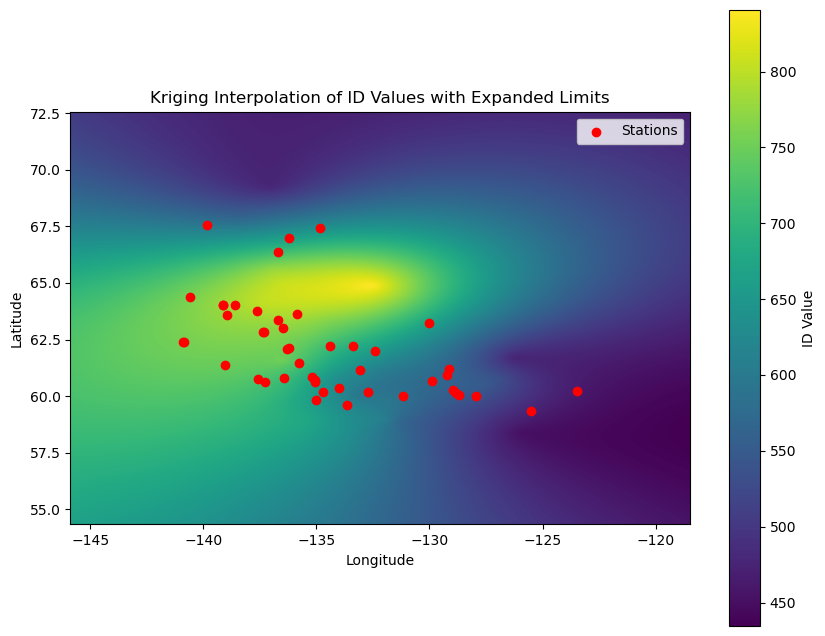

In [ ]:

def point_to_grid(lons:np.array, lats:np.array, values:np.array, buffer:int=10) -> list[np.array,np.array,np.array]:
    """
    Interpolates point data to a regular grid using Ordinary Kriging.

    Parameters:
    lons (np.array): Array of longitude values of the points.
    lats (np.array): Array of latitude values of the points.
    values (np.array): Array of values at the points to be interpolated.
    buffer (int, optional): Buffer distance in degrees to expand the grid beyond the points. Default is 10.

    Returns:
    tuple: A tuple containing:
        - grid_x (np.array): 2D array of x-coordinates of the grid.
        - grid_y (np.array): 2D array of y-coordinates of the grid.
        - grid_z (np.array): 2D array of interpolated values on the grid.

    Raises:
    ValueError: If input arrays are empty.
    RuntimeError: If Kriging interpolation fails.
    """
    # Ensure input arrays are numpy arrays
    lons = np.array(lons)
    lats = np.array(lats)
    values = np.array(values)

    # Check if input arrays are not empty
    if lons.size == 0 or lats.size == 0 or values.size == 0:
        raise ValueError("Input arrays must not be empty.")

    # Perform Kriging interpolation
    OK = OrdinaryKriging(lons, lats, values, variogram_model='linear', verbose=False, enable_plotting=False, variogram_function="gaussian")
    grid_x, grid_y = np.meshgrid(
        np.linspace(lons.min() - buffer, lons.max() + buffer, 1000),
        np.linspace(lats.min() - buffer, lats.max() + buffer, 1000)
    )

    # Execute Kriging and handle potential errors
    try:
        grid_z, ss = OK.execute('grid', grid_x[0, :], grid_y[:, 0])
    except Exception as e:
        raise RuntimeError(f"Kriging interpolation failed: {e}")

    return grid_x, grid_y, grid_z


# Extract coordinates and id values
lons = stations_gdf['longitude'].values
lats = stations_gdf['latitude'].values
values = stations_gdf['elevation'].values
buffer=5

grid_x, grid_y, grid_z = point_to_grid(lons, lats, values, buffer)
# Plot the results with expanded x and y limits
plt.figure(figsize=(10, 8))
plt.imshow(grid_z.T, extent=(stations_gdf['longitude'].min() - buffer, stations_gdf['longitude'].max() + buffer,
                             stations_gdf['latitude'].min() - buffer, stations_gdf['latitude'].max() + buffer),
           origin='lower', cmap='viridis')

plt.colorbar(label='ID Value')
plt.scatter(stations_gdf['longitude'], stations_gdf['latitude'], c='red', label='Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Kriging Interpolation of ID Values with Expanded Limits')
plt.show()


Next, we grab basin boundaries from AquaCache. The basins, alongside the met stations, are plotted below.

<Axes: >

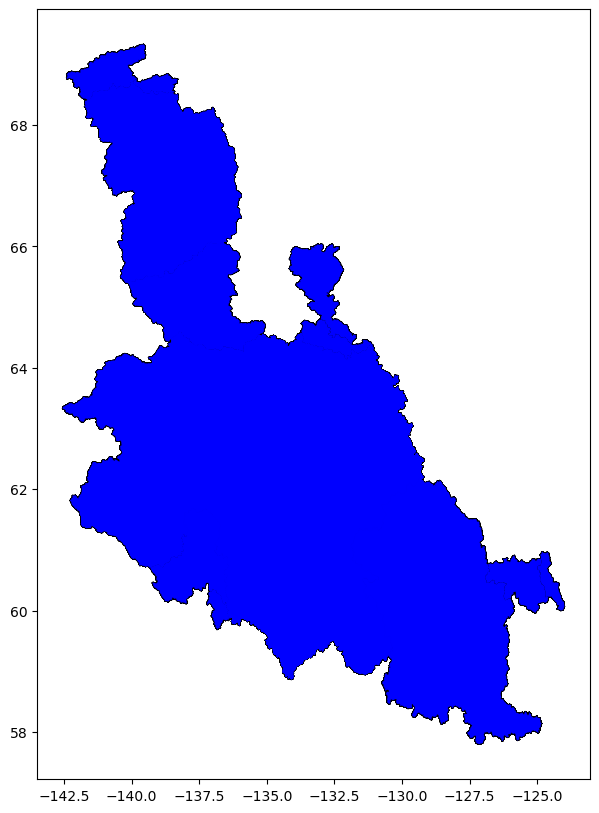

In [557]:

def load_rconfig(renviron_path = Path.home() / "Documents" / ".Renviron"):
    # Define the path to the .Renviron file in the "My Documents" directory
    # Check if the file exists
    if renviron_path.exists():
        # Read the .Renviron file
        with open(renviron_path, 'r') as file:
            renviron_content = [line.strip() for line in file.readlines()]
    env_config = {v[0]: v[1].strip('"') for v in [line.split('=') for line in renviron_content if '=' in line]}
    # Convert numeric values to their appropriate types
    for key, value in env_config.items():
        if value.isdigit():
            env_config[key] = int(value)
        else:
            try:
                env_config[key] = float(value)
            except ValueError:
                pass
    return env_config

# Load database configuration from .Renviron
db_config = load_rconfig()
db_url = f"postgresql://{db_config['aquacacheAdminUser']}:{db_config['aquacacheAdminPass']}@{db_config['aquacacheHost']}:{db_config['aquacachePort']}/aquacache"

# Create a database engine
engine = create_engine(db_url)

basins = {}
res = []
polys = []
# Test the connection by listing tables
with engine.connect() as connection:
    geom_results = connection.execute(text("SELECT ST_AsText(geom) as geom FROM vectors WHERE layer_name = 'Drainage basins';"))
    results = connection.execute(text("SELECT * FROM vectors WHERE layer_name = 'Drainage basins';"))
    
    for geom_row, row in zip(geom_results, results):
        polys.append(wkt.loads(geom_row)[0])
        res.append(row)
basins = gpd.GeoDataFrame(res, geometry=polys, crs="epsg:4269")
basins.set_index("feature_name", inplace=True)

ax = basins.plot(edgecolor="black", facecolor="none", figsize=(10, 10))
basins.plot(ax=ax, marker='o', color='blue', markersize=25)

Here, we define a function to sample the continuous gridded results via basin boundaries. The results for elevation, from the OK earlier, are plotted for basin boundaries.

['08AA003',
 '08AA005',
 '08AA007',
 '08AA008',
 '08AA009',
 '08AA010',
 '08AA011',
 '08AA012',
 '08AB001',
 '08AC001',
 '08AC002',
 '09AA001',
 '09AA004',
 '09AA012',
 '09AA013',
 '09AA017',
 '09AB001',
 '09AB004',
 '09AB008',
 '09AB010',
 '09AC001',
 '09AC007',
 '09AD002',
 '09AE002',
 '09AE003',
 '09AE006',
 '09AG001',
 '09AG002',
 '09AH001',
 '09AH003',
 '09AH004',
 '09BA001',
 '09BB001',
 '09BC001',
 '09BC002',
 '09BC004',
 '09CA001',
 '09CA002',
 '09CA004',
 '09CA006',
 '09CB001',
 '09CD001',
 '09DA001',
 '09DB001',
 '09DC005',
 '09DC006',
 '09DC007',
 '09DD003',
 '09DD004',
 '09EA003',
 '09EA004',
 '09EA005',
 '09EA006',
 '09EB001',
 '09EB003',
 '09EB004',
 '09FA001',
 '09FB002',
 '09FB003',
 '09FC001',
 '09FD002',
 '09FD003',
 '10AA001',
 '10AA004',
 '10AA005',
 '10AA006',
 '10AB001',
 '10AC005',
 '10AD002',
 '10BD001',
 '10BE001',
 '10DB001',
 '10MA001',
 '10MA002',
 '10MA003',
 '10MB003',
 '10MB004',
 '10MD001',
 '10MD002',
 '29AB002',
 '29AB005',
 '29AB007',
 '29AB009',
 '29

In [564]:
# Create a database engine
engine = create_engine(db_url)

gdf = {}
res = []
polys = []


stations = basins.index.to_list()

def list_to_sql_string(lst):
    return ", ".join([f"'{item}'" for item in lst])


with engine.connect() as connection:
    res = connection.execute(text(f"SELECT timeseries_id, parameter_id, location FROM timeseries WHERE location IN ({list_to_sql_string(stations)});"))

timeseries_df = pd.DataFrame(data=res.fetchall(), columns=res.keys())
timeseries_df.set_index(timeseries_df.columns[0], inplace=True)
parameter_ids = timeseries_df["parameter_id"]
timeseries_ids = timeseries_df.index.tolist()


with engine.connect() as connection:
    res = connection.execute(text(f"SELECT parameter_id, param_name FROM parameters WHERE parameter_id IN ({list_to_sql_string(parameter_ids)});"))


param_df = pd.DataFrame(data=res.fetchall(), columns=res.keys())
param_df.set_index(param_df.columns[0], inplace=True)
param_df = param_df["param_name"].to_dict()

timeseries_df["param_name"] = timeseries_df["parameter_id"].map(param_df)

with engine.connect() as connection:
    res = connection.execute(text(f"SELECT date, timeseries_id, value FROM measurements_calculated_daily WHERE timeseries_id IN ({list_to_sql_string(timeseries_ids)});"))


df = pd.DataFrame(data=res.fetchall(), columns=res.keys())
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)
df["value"] = df["value"].astype(float)

# Group the DataFrame by 'timeseries_id' and pivot to create columns for each timeseries_id
df_grouped = df.pivot_table(index=df.index, columns='timeseries_id', values='value')

# Rename the columns to include 'timeseries_' prefix for clarity
#df_grouped.columns = [f"timeseries_{col}" for col in df_grouped.columns]


# Set the columns as a MultiIndex with 'param_name' and 'location'
df_grouped.columns = pd.MultiIndex.from_tuples(
    [(timeseries_df.loc[col, 'param_name'], timeseries_df.loc[col, 'location']) for col in df_grouped.columns],
    names=['param_name', 'location']
)
# Reset the index to make the DataFrame easier to work with


df_grouped

param_name      flow water level                        flow water level  \
location     08AA003     08AA003   08AA005   08AA007 08AA008     08AA008   
date                                                                       
1902-05-01       NaN         NaN       NaN       NaN     NaN         NaN   
1902-05-02       NaN         NaN       NaN       NaN     NaN         NaN   
1902-05-03       NaN         NaN       NaN       NaN     NaN         NaN   
1902-05-04       NaN         NaN       NaN       NaN     NaN         NaN   
1902-05-05       NaN         NaN       NaN       NaN     NaN         NaN   
...              ...         ...       ...       ...     ...         ...   
2025-03-22  8.894896    3.503622  2.145722  2.120319     NaN    2.120319   
2025-03-23  8.867049    3.506976  2.141639  2.119847     NaN    2.119847   
2025-03-24  8.544340    3.499319  2.139493  2.119049     NaN    2.119049   
2025-03-25  6.584271    3.442128  2.135451  2.118340     NaN    2.118340   
2025-03-26  5.723082    3.418352  2.132799  2.117839     NaN    2.117839   

param_name    flow water level      flow water level  ... temperature, water  \
location   08AA009     08AA009   08AA010     08AA010  ...            10AA005   
date                                                  ...                      
1902-05-01     NaN         NaN       NaN         NaN  ...                NaN   
1902-05-02     NaN         NaN       NaN         NaN  ...                NaN   
1902-05-03     NaN         NaN       NaN         NaN  ...                NaN   
1902-05-04     NaN         NaN       NaN         NaN  ...                NaN   
1902-05-05     NaN         NaN       NaN         NaN  ...                NaN   
...            ...         ...       ...         ...  ...                ...   
2025-03-22     NaN    0.517160  7.912118    3.176858  ...                NaN   
2025-03-23     NaN    0.525170  7.894583    3.176493  ...                NaN   
2025-03-24     NaN    0.545295  7.877187    3.176125  ...                NaN   
2025-03-25     NaN    0.551406  7.853993    3.175594  ...                NaN   
2025-03-26     NaN    0.549227  7.844267    3.175353  ...                NaN   

param_name                                                            flow  \
location   10AA006 10AB001 10MA002 10MB003 10MB004 10MD001 10MD002 YEC-MRM   
date                                                                         
1902-05-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1902-05-02     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1902-05-03     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1902-05-04     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1902-05-05     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2025-03-22     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-03-23     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-03-24     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-03-25     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2025-03-26     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

param_name          
location   YEC-MRW  
date                
1902-05-01     NaN  
1902-05-02     NaN  
1902-05-03     NaN  
1902-05-04     NaN  
1902-05-05     NaN  
...            ...  
2025-03-22     NaN  
2025-03-23     NaN  
2025-03-24     NaN  
2025-03-25     NaN  
2025-03-26     NaN  

[39827 rows x 254 columns]

In [567]:
# Summarize df_grouped by year
df_grouped_summary = df_grouped.groupby(df_grouped.index.year).max()

# Display the summarized DataFrame
df_grouped_summary

param_name        flow water level                           flow water level  \
location       08AA003     08AA003   08AA005   08AA007    08AA008     08AA008   
date                                                                            
1902               NaN         NaN       NaN       NaN        NaN         NaN   
1903               NaN         NaN       NaN       NaN        NaN         NaN   
1904               NaN         NaN       NaN       NaN        NaN         NaN   
1905               NaN         NaN       NaN       NaN        NaN         NaN   
1906               NaN         NaN       NaN       NaN        NaN         NaN   
...                ...         ...       ...       ...        ...         ...   
2021        200.000000    3.977000  3.533000  2.801000  19.400000    2.798531   
2022        233.756944    5.373719  3.424000  3.035000  27.700001    3.034003   
2023        162.690058    5.353774  3.313000  2.567000  12.300000    2.566552   
2024        224.500000    4.505750  2.864983  2.539694  10.804167    2.539694   
2025         21.327778    3.736736  2.400632  2.196052        NaN    2.196052   

param_name       flow water level       flow water level  ...  \
location      08AA009     08AA009    08AA010     08AA010  ...   
date                                                      ...   
1902              NaN         NaN        NaN         NaN  ...   
1903              NaN         NaN        NaN         NaN  ...   
1904              NaN         NaN        NaN         NaN  ...   
1905              NaN         NaN        NaN         NaN  ...   
1906              NaN         NaN        NaN         NaN  ...   
...               ...         ...        ...         ...  ...   
2021         7.250000    1.376000  23.299999    3.423000  ...   
2022        13.273264    1.675194  24.600000    3.445000  ...   
2023        11.058333    1.595583  19.799999    3.384000  ...   
2024         2.094618    1.314153  17.347917    3.346128  ...   
2025              NaN    1.602608   9.749236    3.216372  ...   

param_name temperature, water                                              \
location              10AA005    10AA006 10AB001    10MA002       10MB003   
date                                                                        
1902                      NaN        NaN     NaN        NaN           NaN   
1903                      NaN        NaN     NaN        NaN           NaN   
1904                      NaN        NaN     NaN        NaN           NaN   
1905                      NaN        NaN     NaN        NaN           NaN   
1906                      NaN        NaN     NaN        NaN           NaN   
...                       ...        ...     ...        ...           ...   
2021                      NaN  14.408333     2.5  17.504167     11.995833   
2022                      NaN   5.400000     NaN  15.662500  99999.000000   
2023                      NaN        NaN     NaN        NaN           NaN   
2024                      NaN        NaN     NaN        NaN           NaN   
2025                      NaN        NaN     NaN        NaN           NaN   

param_name                                        flow             
location      10MB004    10MD001    10MD002    YEC-MRM    YEC-MRW  
date                                                               
1902              NaN        NaN        NaN        NaN        NaN  
1903              NaN        NaN        NaN        NaN        NaN  
1904              NaN        NaN        NaN        NaN        NaN  
1905              NaN        NaN        NaN        NaN        NaN  
1906              NaN        NaN        NaN        NaN        NaN  
...               ...        ...        ...        ...        ...  
2021        13.041667  16.085714   4.991667  38.320104  70.521779  
2022        12.582609  12.920833  13.366667  54.268209  59.933380  
2023              NaN        NaN        NaN  48.566123  83.052029  
2024              NaN        NaN        NaN  24.693401  48.

In [545]:
timeseries_df

,parameter_id,location,param_name
timeseries_id,,,
1104,1251,09AE003,"temperature, water"
1105,1251,09AG001,"temperature, water"
40,1165,09AE003,water level
43,1150,09AG001,flow
39,1150,09AE003,flow
44,1165,09AG001,water level


C:\Users\esniede\AppData\Local\Temp\ipykernel_28016\1036321733.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf = gdf.assign(area=gdf.geometry.area).sort_values(by="area", ascending=False)


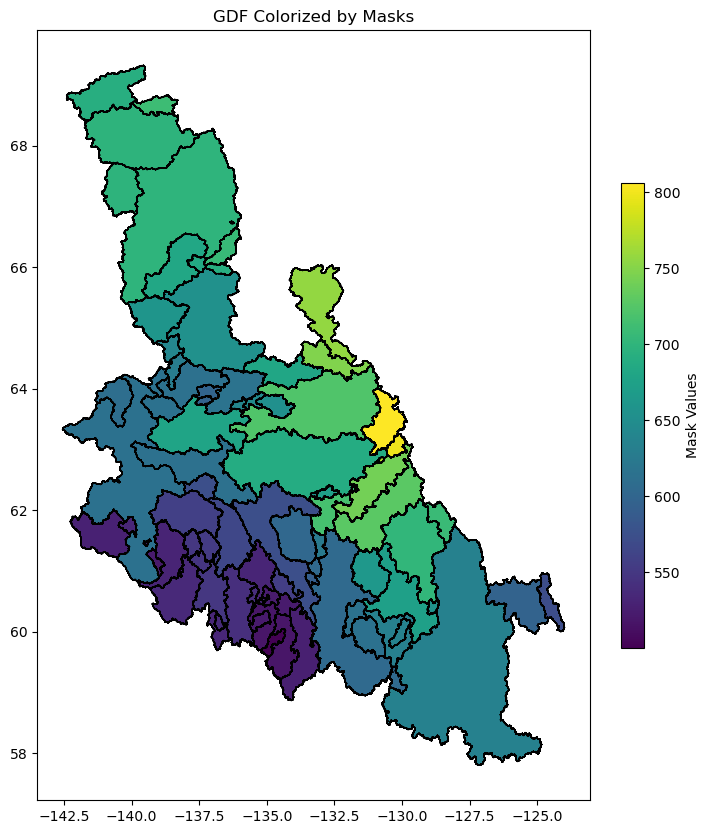

In [ ]:
import matplotlib as mpl
from rasterio.transform import from_bounds



def aggregate_gridded_results_by_poly(grid_x, grid_y, grid_z, gdf):

    # Create a raster template based on grid_x and grid_y
    transform = rasterio.transform.from_bounds(
        grid_x.min(), grid_y.min(), grid_x.max(), grid_y.max(),
        grid_x.shape[1], grid_x.shape[0]
    )

    # Convert polygons to raster masks
    raster_masks = {idx: geometry_mask([geom], transform=transform, invert=True, out_shape=grid_x.shape) 
                    for idx, geom in gdf.geometry.items()}

    mean_values = {idx: grid_z[mask].mean() for idx, mask in raster_masks.items()}

    return mean_values


grid_x, grid_y, grid_z = point_to_grid(lons, lats, values)
masks = aggregate_gridded_results_by_poly(grid_x, grid_y, grid_z, gdf)

# Plot the GeoDataFrame with color based on the masks
fig, ax = plt.subplots(figsize=(10, 10))
gdf = gdf.assign(area=gdf.geometry.area).sort_values(by="area", ascending=False)
# Normalize the mask values for the color map
norm = mpl.colors.Normalize(vmin=min(masks.values()), vmax=max(masks.values()))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Plot the GeoDataFrame with color based on the masks
gdf.plot(ax=ax, color=[plt.cm.viridis(norm(masks[idx])) for idx in gdf.index], edgecolor="black")

# Add a colorbar
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Mask Values")

plt.title("GDF Colorized by Masks")
plt.show()


The cell below grabs two variables, drought code and date (as day of year) for freeze and snowfree dataframes. Results are agrigated into a single multi-indexed [year,(basin,param)] dataframe.

In [337]:
years = np.unique(np.concatenate([freeze["freeze_date"].dt.year, snowfree["snowfree_date"].dt.year]))
years = years[~np.isnan(years)]

df = pd.DataFrame(index=years, columns=pd.MultiIndex.from_product([gdf.index, ["freeze_doy", "freeze_dc", "snowfree_doy", "snowfree_dc"]]))

datasets = {"freeze": freeze, "snowfree": snowfree}
params = ["dc", "doy"]

# for freeze and thaw df
for key in datasets:
    ds = datasets[key]

    # for each year
    for year in years:

        # for each param (DAY OF YEAR [DOY] and DROUGHT DODE [DC])
        for param in params:
            
            # subset  correct date and non-null
            idx = (ds[f"{key}_date"].dt.year == year) & ds[f"{key}_dc"].notnull()
            

            # get the correct param
            if param == "dc":
                values = ds.loc[idx, f"{key}_dc"].astype(float).values
            elif param == "doy":
                values = ds.loc[idx, f"{key}_date"].dt.dayofyear.astype(float).values
            else:
                raise ValueError("Invalid parameter. Must be either 'dc' or 'doy'.")
            

            # if valid data, get basin avgs
            if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
                lats = ds.loc[idx, "geometry"].y.values
                lons = ds.loc[idx, "geometry"].x.values

                grid_x, grid_y, grid_z = point_to_grid(lons, lats, values)
                basin_avgs = grid_to_poly(grid_x, grid_y, grid_z, gdf)
                
                for basin in gdf.index:
                    df.loc[year, (basin, f"{key}_{param}")] = basin_avgs[basin]
            
            # 
            elif (len(values) == 1) | (values.var() == 0):
                for basin in gdf.index:
                    df.loc[year, (basin, f"{key}_{param}")] = values[0]

            else: 
            # if no values, nan
                for basin in gdf.index:
                 df.loc[year, (basin, f"{key}_{param}")] = np.nan


C:\Users\esniede\AppData\Local\Temp\ipykernel_28016\1149688615.py:33: RuntimeWarning: Degrees of freedom <= 0 for slice
  if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
c:\Users\esniede\Documents\github\YGwater\.conda\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\esniede\Documents\github\YGwater\.conda\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\esniede\AppData\Local\Temp\ipykernel_28016\1149688615.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice
  elif (len(values) == 1) | (values.var() == 0):
C:\Users\esniede\AppData\Local\Temp\ipykernel_28016\1149688615.py:33: RuntimeWarning: Degrees of freedom <= 0 for slice
  if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
c:\Users\esniede\Documents\github\YGwater\.conda\Lib\site-packa

In [475]:
df.head()

feature_name     08AA003                                          08AA005  \
              freeze_doy   freeze_dc snowfree_doy snowfree_dc  freeze_doy   
2002          287.349305   428.90109          NaN         NaN  287.718544   
2003          298.159868  528.896552   126.007788  165.492232  298.276622   
2004          302.229825  488.903226   128.517241  122.896552  302.353669   
2005          275.080303  426.569756   125.833333  144.999263  276.795279   
2006          292.484848       477.0   137.694134  118.787879  292.484848   

feature_name                                          08AA007              \
               freeze_dc snowfree_doy snowfree_dc  freeze_doy   freeze_dc   
2002          430.239861          NaN         NaN  287.975585  428.495656   
2003          528.896552   125.675112  169.961271  298.407054  528.896552   
2004          488.903226   128.517241  122.896552  302.465627  488.903226   
2005          429.162515   125.833333  149.047574  276.687589  428.164694   
2006               477.0   137.129479  118.787879  292.484848       477.0   

feature_name  ...      30MA005                 YEC-MRM              \
              ... snowfree_doy snowfree_dc  freeze_doy   freeze_dc   
2002          ...          NaN         NaN  287.513142  465.228357   
2003          ...   123.124762  279.595147  297.229737  528.896552   
2004          ...   128.517241  122.896552  301.157816  488.903226   
2005          ...   125.833333  188.955814  286.059975   464.49401   
2006          ...   111.631974  118.787879  292.484848       477.0   

feature_name                              YEC-MRW                           \
             snowfree_doy snowfree_dc  freeze_doy   freeze_dc snowfree_doy   
2002                  NaN         NaN  287.523904  464.705356          NaN   
2003           123.482839  234.963043  297.307734  528.896552   123.406651   
2004           128.517241  122.896552  301.272767  488.903226   128.517241   
2005           125.833333  148.029881  286.418239  463.959069   125.833333   
2006           123.888575  118.787879  292.484848       477.0   123.788288   

feature_name              
             snowfree_dc  
2002                 NaN  
2003          234.880694  
2004          122.896552  
2005          151.830727  
2006          118.787879  

[5 rows x 400 columns]

Next, we read theannual peak flow/stage and SWE results for select monitoring locaitons

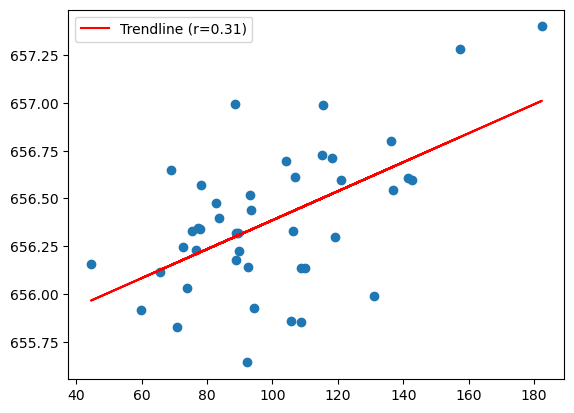

In [ ]:
from scipy.stats import linregress

annual_hydro = pd.read_excel("data/annual_peaks.xlsx", header=[0, 1], index_col=0)
annual_hydro.index = annual_hydro.index.astype(int)


# last 4 station matches are a bit uncertain (except yukon @ dawson)..
rename_locations = {"Marsh Lake": "09AB004", "Teslin Lake": "09AE002", "Pelly River": "09BC001", "Stewart River": "09DD003", "Klondike River (lower Yukon SWE)": "09EA003", "Yukon River at Dawson ": "09EB001","Porcupine River": "09FD002", "Liard River": "10AA001"}
for name, code in rename_locations.items():
    annual_hydro.rename(columns={name: code}, level=0, inplace=True)


plt.plot(annual_hydro.loc[:2022,("09AB004", "April SWE%")],annual_hydro.loc[:2022,("09AB004", "Elevation")],'o')
# Calculate the linear regression

y = annual_hydro.loc[:2022, ("09AB004", "Elevation")].values
x = annual_hydro.loc[:2022, ("09AB004", "April SWE%")].values
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the trendline
plt.plot(x, slope * x + intercept, color='red', label=f'Trendline (r={r_value**2:.2f})')

# Add legend
plt.legend()

Finally, we merge both dataframes (drought code data and anual hydro data) into a single dataframe. We collapse the station index, in favour of one-hot-encoded station informaiton. This allows us to use the data from all stations for model training, while providing the model with necessary information to distinquish between basins. Currently, stage and discharge are merged into a single column, then normalized. Ultimately, both stage and discharge should be used as independant variables and normalization should be applied on a staiton basis (e.g., prior to collapsing/stacking). TODO.

In [ ]:
# Ensure both dataframes have the same index type
df.index = df.index.astype(int)
annual_hydro.index = annual_hydro.index.astype(int)

# Merge the dataframes on their indices
merged_df = pd.merge(df, annual_hydro, left_index=True, right_index=True, how='inner')

transposed_df = merged_df.stack(level=0)
transposed_df = transposed_df.reset_index(level=1).rename(columns={"level_1": "station"})
transposed_df = pd.get_dummies(transposed_df, columns=["station"], drop_first=True)
transposed_df["Max Q/Level"] = transposed_df[["Max Q", "Max Level", "Elevation"]].apply(lambda x: x.dropna().values[0] if not x.dropna().empty else np.nan, axis=1)
transposed_df.drop(columns=["Max Q", "Max Level", "Elevation"], inplace=True)


C:\Users\esniede\AppData\Local\Temp\ipykernel_28016\3192188793.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  transposed_df = merged_df.stack(level=0)


Lastly, we train two models. A multi-variate linear regression model and a random forest model. Peak annual values, and freeze-up data are used to calculate snowfree variables.

NSE value for Linear Regression: -0.3498267514187279
NSE value for Random Forest: 0.24990319453039622


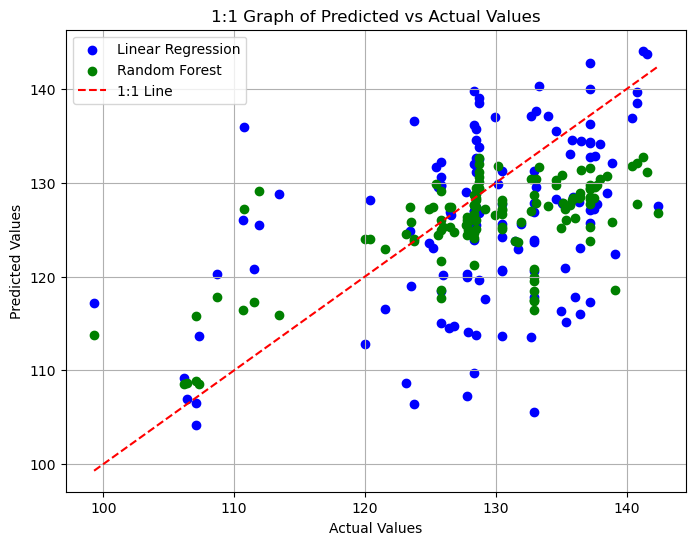

In [444]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Drop rows with missing values in df2
df2_cleaned = transposed_df.dropna()

# Separate features (X) and target (y)
X = df2_cleaned.drop(columns=["snowfree_dc", "snowfree_doy"])
y = df2_cleaned["snowfree_doy"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Apply z-normalization to the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_linear = model.predict(X_test)

# Initialize and train the random forest model
model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = model.predict(X_test)

# Calculate R2 values

def nse(y_true, y_pred):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE) coefficient.

    Parameters:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values.

    Returns:
    float: NSE coefficient.
    """
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (numerator / denominator)

nse_linear = nse(y_test, y_pred_linear)
nse_rf = nse(y_test, y_pred_rf)

print(f"NSE value for Linear Regression: {nse_linear}")
print(f"NSE value for Random Forest: {nse_rf}")

# Plot the 1:1 graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, color='blue', label='Linear Regression')
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='1:1 Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('1:1 Graph of Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()